In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List
import json
import pickle

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data
from transformer import LGBMLeavesEncoder, XGBLeavesEncoder, CATBLeavesEncoder

PyTorch version: 2.4.1
PyTorch Lightning version: 2.4.0


In [2]:
from torch_frame.nn import ExcelFormer
from torch_frame.transforms import CatToNumTransform, MutualInformationSort
from torch_frame.data import Dataset


In [3]:
# set seeds for reproducibility
np.random.seed(2112)
pl.seed_everything(2112)

Seed set to 2112


2112

In [4]:
# useful callbacks
class LearningRateMonitor(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % 100 == 0:  # Log every 100 batches
            lr = pl_module.optimizers().param_groups[0]['lr']
            pl_module.log('learning_rate', lr, prog_bar=True)   

class BestValRMSELogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_rmse = float('inf')

    def on_validation_epoch_end(self, trainer, pl_module):
        current_val_rmse = trainer.callback_metrics.get('val_rmse')
        if current_val_rmse is not None:
            self.best_val_rmse = min(self.best_val_rmse, current_val_rmse)
            pl_module.log('best_val_rmse', self.best_val_rmse, prog_bar=True)

***
### load and preprocess data

In [5]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [6]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])
text_cols = ["LudRules",]

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 1


In [7]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    # scale=True,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


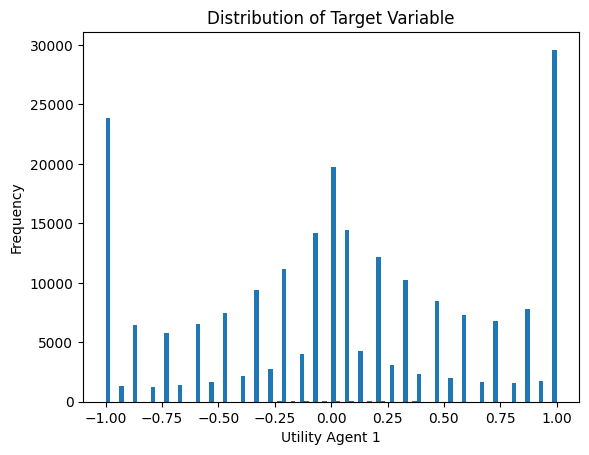

In [8]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [9]:
cat_input_dims = df_train[categorical_cols].nunique(axis=0).values.tolist()
print(cat_input_dims)

[72, 72, 4, 3, 4]


***
### train model


In [10]:
class MLP(pl.LightningModule):

    def __init__(self, 
            num_input_dim: int,
            cat_input_dims: list[int],
            output_dim: int,
            layers: str,
            dropout: float,
            embedding_dropout: float,
            learning_rate: float = 1e-3,
            weight_decay: float = 1e-5,
            initialization: str = 'kaiming_uniform',
            embedding_dim: Optional[List[int]] = None,
            pct_start: float = 0.2,
            div_factor: float = 10.0,
            final_div_factor: float = 1e4,
        ):
        super().__init__()
        self.save_hyperparameters()
        self.dropout = dropout
        self.embedding_dropout = embedding_dropout
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

        # Initialize embedding dimensions if not provided
        if embedding_dim is None:
            # Rule of thumb: min(50, num_unique // 2 + 1) for each categorical feature
            embedding_dim = [min(50, int(1 + np.ceil(np.sqrt(dim)))) for dim in cat_input_dims]

        elif len(embedding_dim) != len(cat_input_dims):
            raise ValueError("Length of embedding_dim must match number of categorical features.")

        self.embedding_dim = embedding_dim

        # Create embedding layers
        self.create_embeddings(cat_input_dims, embedding_dim)

        # Create backbone layers
        self.create_backbone(num_input_dim, layers)

        # Create head layers
        self.create_head(output_dim)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.initialization = initialization

        self._init_weights()

        # Initialize lists to store validation outputs
        self.validation_targets = []
        self.validation_predictions = []

    def create_embeddings(self, cat_input_dims: list[int], embedding_dim: list[int]):
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_input_dims, embedding_dim)]
        )
        self.embedding_dropout_layer = nn.Dropout(self.embedding_dropout)

    def create_backbone(self, num_input_dim: int, layers: str):
        # Calculate total input dimension after embeddings
        total_embedding_dim = sum(self.embedding_dim)
        total_input_dim = num_input_dim + total_embedding_dim

        # Parse layers string
        layer_sizes = [int(size) for size in layers.split('-')]

        # Create backbone network layers
        backbone_layers = []
        prev_size = total_input_dim
        for size in layer_sizes:
            backbone_layers.extend([
                nn.BatchNorm1d(prev_size),
                nn.Linear(prev_size, size),
                nn.ReLU(),
                nn.Dropout(self.hparams.dropout),
            ])
            prev_size = size
        self.backbone = nn.Sequential(*backbone_layers)
        self.backbone_output_size = prev_size

    def create_head(self, output_dim: int):
        # Output layer
        self.head = nn.Sequential(
            nn.BatchNorm1d(self.backbone_output_size),
            nn.Linear(self.backbone_output_size, output_dim)
        )

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if any(module is m for m in self.head.modules()):
                    nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('tanh'))
                else:
                    if self.initialization == 'kaiming_uniform':
                        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'kaiming_normal':
                        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'xavier_uniform':
                        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                    elif self.initialization == 'xavier_normal':
                        nn.init.xavier_normal_(module.weight, gain=nn.init.calculate_gain('relu'))
                    else:
                        raise ValueError(f"Unsupported initialization method: {self.initialization}")
                
                # Initialize bias to small values
                if module.bias is not None:
                    nn.init.uniform_(module.bias, -0.1, 0.1)

    def forward(self, x_num, x_cat):
        # Process categorical variables
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        embedded = self.embedding_dropout_layer(embedded)
        
        # Concatenate numerical and embedded categorical features
        x = torch.cat([x_num, embedded], dim=1)
        
        # Pass through backbone
        x = self.backbone(x)
        
        # Pass through head
        x = self.head(x)
        x = nn.functional.hardtanh(x)

        return x.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('valid_loss', loss, prog_bar=True)
        # Store targets and predictions for later use
        self.validation_targets.append(y)
        self.validation_predictions.append(y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        if len(batch) == 2:
            x_num, x_cat = batch
        elif len(batch) == 3:
            x_num, x_cat, _ = batch
        y_hat = self(x_num, x_cat)
        return y_hat

    def on_validation_epoch_end(self):
        # Concatenate all targets and predictions
        y = torch.cat(self.validation_targets)
        y_hat = torch.cat(self.validation_predictions)
        rmse = torch.sqrt(F.mse_loss(y_hat, y))
        self.log('val_rmse', rmse, prog_bar=True)
        # Clear the lists for next epoch
        self.validation_targets.clear()
        self.validation_predictions.clear()
                
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay,
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=self.pct_start,
            div_factor=self.div_factor,
            final_div_factor=self.final_div_factor,
            anneal_strategy='cos',
            cycle_momentum=True,
            base_momentum=0.85,
            max_momentum=0.95,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [11]:
params = {
    'batch_size': 448,
    'dropout': 0.0,
    'embedding_dropout': 0.2,
    'input_layer_size': 1024,
    'n_layers': 4,
    'learning_rate': 0.0017902381479678216,
    'weight_decay': 0.0003339096474946611,
    'pct_start': 0.05,
    'div_factor': 74.0,
    'final_div_factor': 39.31519465021811
}

In [12]:
# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=63,
        random_state=2112,
        verbosity=-1,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train_leaves_lgbm = lgbm_encoder.transform(X_train, verbose=True)
    X_valid_leaves_lgbm = lgbm_encoder.transform(X_valid)
    
    catb_encoder = CATBLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        random_state=2112,
        iterations=100,
        depth=6,
        verbose=False,
    )
    catb_encoder.fit(X_train, y_train)
    X_train_leaves_catb = catb_encoder.transform(X_train, verbose=True)
    X_valid_leaves_catb = catb_encoder.transform(X_valid)
    
    X_train = pd.concat([X_train, X_train_leaves_lgbm], axis=1)
    X_valid = pd.concat([X_valid, X_valid_leaves_lgbm], axis=1) 

    X_train = pd.concat([X_train, X_train_leaves_catb], axis=1)
    X_valid = pd.concat([X_valid, X_valid_leaves_catb], axis=1)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns + catb_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    break

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
Adding 100 new columns from LGBM leaves
Adding 100 new columns from CATB leaves
List of oof scores: []
Average oof score: nan


/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
from torch_frame import TaskType, stype
from torch_frame.utils import infer_df_stype

In [14]:
import os 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

device = torch.device('mps')
# device = torch.device('cpu')

In [15]:
df_train = pd.concat([X_train, y_train], axis=1)
df_valid = pd.concat([X_valid, y_valid], axis=1)

In [16]:
col_to_stype = {col: stype.numerical for col in numerical_cols}
col_to_stype.update({col: stype.categorical for col in _categorical_cols})
col_to_stype.update({"utility_agent1": stype.numerical})

In [17]:
#_df = df_train[numerical_cols + categorical_cols + ['utility_agent1']]

train_dataset = Dataset(
    df_train, 
    col_to_stype=col_to_stype,
    target_col='utility_agent1',
)
train_dataset.materialize(
    device=device
)

Dataset()

In [18]:
valid_dataset = Dataset(
    df_valid, 
    col_to_stype=col_to_stype,
    target_col='utility_agent1',
)
valid_dataset.materialize(
    device=device
)

Dataset()

In [19]:
train_tensor_frame = train_dataset.tensor_frame
valid_tensor_frame = valid_dataset.tensor_frame

In [20]:
train_tensor_frame

TensorFrame(
  num_cols=575,
  num_rows=190558,
  numerical (370): ['Absolute', 'AddDecision', 'AddEffect', 'AddEffectFrequency', 'AdvantageP1', 'AlquerqueBoard', 'AlquerqueBoardWithFourTriangles', 'AlquerqueBoardWithOneTriangle', 'AlquerqueBoardWithTwoTriangles', 'AlquerqueTiling', 'Asymmetric', 'AsymmetricForces', 'BackgammonStyle', 'BackwardDirection', 'BallComponent', 'BishopComponent', 'BoardCoverageDefault', 'BoardSitesOccupiedChangeAverage', 'BoardSitesOccupiedChangeLineBestFit', 'BoardSitesOccupiedChangeSign', 'BoardSitesOccupiedMaxIncrease', 'BoardSitesOccupiedMaximum', 'BoardSitesOccupiedMedian', 'BoardStyle', 'Boardless', 'BranchingFactorAverage', 'BranchingFactorChangeAverage', 'BranchingFactorChangeMaxDecrease', 'BranchingFactorChangeMaxIncrease', 'BranchingFactorChangeNumTimesn', 'BranchingFactorChangeSign', 'CanMove', 'CaptureSequenceFrequency', 'CheckmateWinFrequency', 'ChessComponent', 'CircleShape', 'Comparison', 'Completion', 'ComponentStyle', 'ConcentricTiling', 'Co

In [21]:
valid_tensor_frame

TensorFrame(
  num_cols=575,
  num_rows=42676,
  numerical (370): ['Absolute', 'AddDecision', 'AddEffect', 'AddEffectFrequency', 'AdvantageP1', 'AlquerqueBoard', 'AlquerqueBoardWithFourTriangles', 'AlquerqueBoardWithOneTriangle', 'AlquerqueBoardWithTwoTriangles', 'AlquerqueTiling', 'Asymmetric', 'AsymmetricForces', 'BackgammonStyle', 'BackwardDirection', 'BallComponent', 'BishopComponent', 'BoardCoverageDefault', 'BoardSitesOccupiedChangeAverage', 'BoardSitesOccupiedChangeLineBestFit', 'BoardSitesOccupiedChangeSign', 'BoardSitesOccupiedMaxIncrease', 'BoardSitesOccupiedMaximum', 'BoardSitesOccupiedMedian', 'BoardStyle', 'Boardless', 'BranchingFactorAverage', 'BranchingFactorChangeAverage', 'BranchingFactorChangeMaxDecrease', 'BranchingFactorChangeMaxIncrease', 'BranchingFactorChangeNumTimesn', 'BranchingFactorChangeSign', 'CanMove', 'CaptureSequenceFrequency', 'CheckmateWinFrequency', 'ChessComponent', 'CircleShape', 'Comparison', 'Completion', 'ComponentStyle', 'ConcentricTiling', 'Con

In [22]:
categorical_transform = CatToNumTransform()
categorical_transform.fit(train_dataset.tensor_frame, train_dataset.col_stats)

In [23]:
train_tensor_frame = categorical_transform(train_tensor_frame)
valid_tensor_frame = categorical_transform(valid_tensor_frame)

In [24]:
col_stats = categorical_transform.transformed_stats

In [25]:
mutual_info_sort = MutualInformationSort(task_type=TaskType.REGRESSION)

In [26]:
mutual_info_sort.fit(train_tensor_frame, col_stats)

In [27]:
train_tensor_frame

TensorFrame(
  num_cols=575,
  num_rows=190558,
  numerical (575): ['Absolute', 'AddDecision', 'AddEffect', 'AddEffectFrequency', 'AdvantageP1', 'AlquerqueBoard', 'AlquerqueBoardWithFourTriangles', 'AlquerqueBoardWithOneTriangle', 'AlquerqueBoardWithTwoTriangles', 'AlquerqueTiling', 'Asymmetric', 'AsymmetricForces', 'BackgammonStyle', 'BackwardDirection', 'BallComponent', 'BishopComponent', 'BoardCoverageDefault', 'BoardSitesOccupiedChangeAverage', 'BoardSitesOccupiedChangeLineBestFit', 'BoardSitesOccupiedChangeSign', 'BoardSitesOccupiedMaxIncrease', 'BoardSitesOccupiedMaximum', 'BoardSitesOccupiedMedian', 'BoardStyle', 'Boardless', 'BranchingFactorAverage', 'BranchingFactorChangeAverage', 'BranchingFactorChangeMaxDecrease', 'BranchingFactorChangeMaxIncrease', 'BranchingFactorChangeNumTimesn', 'BranchingFactorChangeSign', 'CanMove', 'CaptureSequenceFrequency', 'CheckmateWinFrequency', 'ChessComponent', 'CircleShape', 'Comparison', 'Completion', 'ComponentStyle', 'ConcentricTiling', 'Co

In [28]:
train_tensor_frame = mutual_info_sort(train_tensor_frame)
valid_tensor_frame = mutual_info_sort(valid_tensor_frame)

In [29]:
from torch_frame.data.loader import DataLoader

In [30]:
train_loader = DataLoader(train_tensor_frame, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_tensor_frame, batch_size=8192, shuffle=False)

In [31]:
model = ExcelFormer(
    in_channels=16,
    out_channels=1,
    num_layers=4,
    num_cols=train_tensor_frame.num_cols,
    num_heads=2,
    residual_dropout=0.0,
    diam_dropout=0.0,
    aium_dropout=0.0,
    mixup=None,
    col_stats=mutual_info_sort.transformed_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)

In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params:,}')

Total number of parameters: 44,178


In [33]:
from torchinfo import summary

In [34]:
model_summary = summary(model)
print(model_summary)

Layer (type:depth-idx)                   Param #
ExcelFormer                              --
├─StypeWiseFeatureEncoder: 1-1           --
│    └─ModuleDict: 2-1                   --
│    │    └─ExcelFormerEncoder: 3-1      36,800
├─ModuleList: 1-2                        --
│    └─ExcelFormerConv: 2-2              --
│    │    └─LayerNorm: 3-2               32
│    │    └─DiaM: 3-3                    1,088
│    │    └─LayerNorm: 3-4               32
│    │    └─AiuM: 3-5                    544
│    └─ExcelFormerConv: 2-3              --
│    │    └─LayerNorm: 3-6               32
│    │    └─DiaM: 3-7                    1,088
│    │    └─LayerNorm: 3-8               32
│    │    └─AiuM: 3-9                    544
│    └─ExcelFormerConv: 2-4              --
│    │    └─LayerNorm: 3-10              32
│    │    └─DiaM: 3-11                   1,088
│    │    └─LayerNorm: 3-12              32
│    │    └─AiuM: 3-13                   544
│    └─ExcelFormerConv: 2-5              --
│    │    └

In [35]:
# model = torch.compile(model, dynamic=True)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
from torch.optim.lr_scheduler import ExponentialLR
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [38]:
from tqdm import tqdm

def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        # Train with FEAT-MIX or HIDDEN-MIX
        # pred_mixedup, y_mixedup = model(tf, mixup_encoded=False)
        y_pred = model(tf)
        loss = F.mse_loss(y_pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(y_pred)
        total_count += len(y_pred)
        optimizer.step()
    return loss_accum / total_count

In [39]:
from torchmetrics import AUROC, Accuracy, MeanSquaredError

In [40]:
metric_computer = MeanSquaredError()
metric_computer = metric_computer.to(device)

In [41]:
@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    metric_computer.reset()
    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        metric_computer.update(pred.view(-1), tf.y.view(-1))
    return metric_computer.compute().item()**0.5

In [42]:
metric = 'RMSE'
best_val_metric = float('inf')
best_test_metric = float('inf')

: 

In [43]:
for epoch in range(1, 50 + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    valid_metric = test(valid_loader)
    # test_metric = test(test_loader)

    best_val_metric = valid_metric

    print(
        f'Train Loss: {train_loss:.4f}, ' 
        f'Train {metric}: {train_metric:.4f}, '
        f'Valid {metric}: {valid_metric:.4f}, '
        f'Best Valid {metric}: {best_val_metric:.4f}'
    )
    lr_scheduler.step()

Epoch: 1: 100%|██████████| 373/373 [05:56<00:00,  1.05it/s]


In [ ]:
# plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
# plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
# plt.legend()
# plt.show()

***
### inference

In [11]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [12]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )
    
    # Select relevant features
    X_test_num = test_processed[numerical_cols]
    X_test_cat = test_processed[categorical_cols]
    
    # Initialize an array to store predictions
    predictions = np.zeros(len(X_test_num))
    
    # Make predictions using each trained model
    for model in trained_models:
        model.eval()
        with torch.no_grad():
            X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32)
            X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.long)
            batch_predictions = model(X_test_num_tensor, X_test_cat_tensor).cpu().numpy().flatten()
        predictions += batch_predictions
    
    # Average the predictions
    predictions /= len(trained_models)
    
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [13]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***